# Titanic experiments
In this notebook, we apply the 4 different types of hierarchical shrinkage using a single decision tree on the titanic dataset, with the (uninformative) feature `PassengerID` included. For each type of shrinkage, we inspect average test set accuracy using 10-fold CV and the feature importances for varying values of lambda.

The main expectation is that the MDI feature importance for `PassengerID` will be much lower for models with shrinkage than without.

In [6]:
from aughs import ShrinkageClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import balanced_accuracy_score
from titanic import preprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
"""
The old way: using sklearn cross-validation. This needlessly retrains the model
many more times than necessary.
"""
X_df, y_df = preprocess(pd.read_csv("../raw_data/titanic/titanic_train.csv"))
lmbs = np.arange(0, 100, 1)
scores = {}
importances = {}
for shrink_mode in ["hs", "hs_entropy", "hs_entropy_2", "hs_log_cardinality"]:
    scores[shrink_mode] = []
    importances[shrink_mode] = []
    for lmb in lmbs:
        clf = ShrinkageClassifier(shrink_mode=shrink_mode, lmb=lmb)
        scores[shrink_mode].append(
            cross_val_score(clf, X_df.values, y_df.values, cv=10, n_jobs=-1,
                            scoring="balanced_accuracy").mean())
        clf.fit(X_df, y_df)
        importances[shrink_mode].append(clf.estimator_.feature_importances_)
    importances[shrink_mode] = np.vstack(importances[shrink_mode])

KeyboardInterrupt: 

In [10]:
def compute_scores_single_fold(train_index, test_index, X, y, lmbs, shrink_mode):
    scores = []
    clf = ShrinkageClassifier(shrink_mode=shrink_mode)
    clf.fit(X[train_index], y[train_index])
    for lmb in lmbs:
        clf.set_shrink_params(X[train_index], shrink_mode=shrink_mode, lmb=lmb)
        scores.append(balanced_accuracy_score(y[test_index], clf.predict(X[test_index])))
    return scores

In [11]:
"""
The new way: using a custom cross-validation. This is much faster.
Using joblib to parallelize the cross-validation (this is also what sklearn
does internally, without parallelization this approach is slower than sklearn).
"""
X_df, y_df = preprocess(pd.read_csv("../raw_data/titanic/titanic_train.csv"))
lmbs = np.arange(0, 100, 1)
scores = {}
importances = {}
for shrink_mode in ["hs", "hs_entropy", "hs_entropy_2", "hs_log_cardinality"]:
    cv = KFold(n_splits=10, shuffle=True)
    shrink_mode_scores = Parallel(n_jobs=-1)(
        delayed(compute_scores_single_fold)(
            train_index, test_index, X_df.values, y_df.values, lmbs, shrink_mode)
            for train_index, test_index in cv.split(X_df.values))
    shrink_mode_scores = np.vstack(shrink_mode_scores)
    scores[shrink_mode] = np.average(shrink_mode_scores, axis=0)

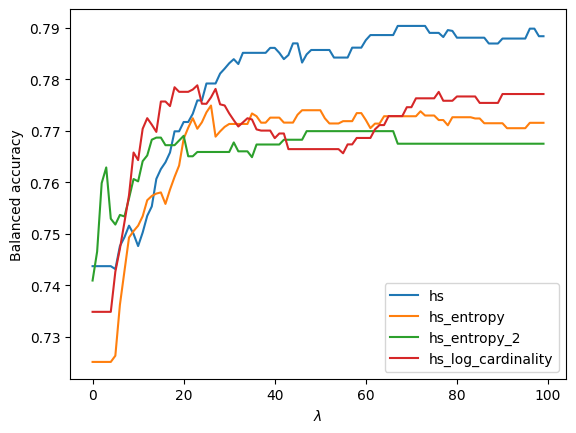

In [12]:
for key in scores:
    plt.plot(lmbs, scores[key], label=key)
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Balanced accuracy")
plt.show()

In [13]:
for key in importances:
    line_objects = plt.plot(lmbs, importances[key])
    plt.legend(line_objects, X_df.columns, bbox_to_anchor=(1.05, 1))
    plt.title(key)
    plt.xlabel("$\lambda$")
    plt.ylabel("Feature importance")
    plt.show()